# Part 5
# Author: Georgios Pligoropoulos < george@pligor.com >

In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from os import path, remove
import numpy as np
import pandas as pd
from csv import QUOTE_ALL
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
import shutil
from sklearn.metrics import r2_score
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import operator
from os.path import isfile, isdir, join
from os import getcwd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeSVD, MICE, \
    MatrixFactorization, BiScaler
from math import floor
from scipy import stats

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
seed = 16011984
random_state = np.random.RandomState(seed=seed)
n_jobs = 1
%matplotlib inline

In [4]:
from advanced_one_hot_encoder import AdvancedOneHotEncoder

**Short sale** explained: http://www.investopedia.com/terms/r/real-estate-short-sale.asp

## Load Data

In [5]:
twin_cities_path = join(getcwd(), 'twin_cities.csv')
df = pd.read_csv(twin_cities_path, delimiter = ',', encoding='utf-8', quoting=QUOTE_ALL, index_col=0)
df.shape

(1111, 20)

## Drop redundant columns
State column does not hold any information since it is the same for all instances
Also we are dropping last sale date as we are advised to not use it but also because it contains lots of nulls

In [6]:
if 'STATE' in df.columns:
    df = df.drop(labels=['STATE'], axis=1)
if 'LastSaleDate' in df.columns:
    df = df.drop(labels=['LastSaleDate'], axis=1)
df.shape

(1111, 18)

### Keep columns for Price Regression

In [7]:
#Regression Columns
#CITY, ZIP, BEDS, BATHS, SQFT, LotSize, YearBuilt, ParkingSpots, HasGarage, LATITUDE, LONGITUDE, ShortSale
XX = df[
    ['CITY', 'ZIP', 'BEDS', 'BATHS', 'SQFT', 'LotSize', 'YearBuilt', 'ParkingSpots', 'HasGarage', 'LATITUDE',
     'LONGITUDE', 'ShortSale', 'LOCATION']
]
XX.shape

(1111, 13)

In [8]:
#target: ListPrice
yy = df['ListPrice']
yy.shape

(1111,)

### Numerify data

In [9]:
if XX['BATHS'].dtype == 'object':
    XX['BATHS'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['BATHS']]
XX['BATHS'].dtype

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


dtype('float64')

#### CITY

In [10]:
print len(XX['CITY'].unique())
XX['CITY'].unique()

6


array([u'St. Paul', u'Shoreview', u'Minneapolis', u'Woodbury',
       u'West St. Paul', u'Maplewood'], dtype=object)

In [11]:
if 'CITY' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='CITY')
XX.shape

(1111, 17)

#### ZIP

In [12]:
#comparing locations and zips lengths
print len(df['LOCATION'].unique())
print len(df['ZIP'].unique())

86
33


In [13]:
if 'ZIP' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='ZIP')
XX.shape

(1111, 48)

#### Year Built to Age

In [14]:
if 'YearBuilt' in XX.columns:
    XX['age'] = 2014 - XX['YearBuilt']
    XX.drop(labels='YearBuilt', axis=1, inplace=True)
assert 'age' in XX.columns
XX.shape

(1111, 48)

#### Has Garage to binary

In [15]:
XX['HasGarage'].unique()

array([u'Garage', u'No Garage'], dtype=object)

In [16]:
if 'Garage' in XX['HasGarage'].unique():
    XX['HasGarage'] = XX['HasGarage'] == 'Garage'
XX['HasGarage'].unique()

array([True, False], dtype=object)

#### Short Sale to binary

In [17]:
XX['ShortSale'].unique()

array([u'N', u'Y'], dtype=object)

In [18]:
if 'Y' in XX['ShortSale'].unique():
    XX['ShortSale'] = XX['ShortSale'] == 'Y'
XX['ShortSale'].unique()

array([False, True], dtype=object)

#### Latitude

In [19]:
if XX['LATITUDE'].dtype == 'object':
    XX['LATITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LATITUDE']]
XX['LATITUDE'].dtype

dtype('float64')

#### Longitude

In [20]:
if XX['LONGITUDE'].dtype == 'object':
    XX['LONGITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LONGITUDE']]
XX['LONGITUDE'].dtype

dtype('float64')

#### Location
We are not converting location in one hot encoding since we are only using it for grouping and not for input in Machine Learning models

In [21]:
# if 'LOCATION' in XX.columns:
#     XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='LOCATION',
#                                                          #nan is not equal to itself
#                                                          check_to_null = lambda vv: vv != vv)
# XX.shape

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
le = LabelEncoder().fit(XX['LOCATION'])

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [24]:
XX['LOCATION'] = le.transform(XX['LOCATION'])
XX['LOCATION'].shape

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/numpy/lib/arraysetops.py:259: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


(1111,)

### Fill the Gaps
Rule of thumb of KNN to pick a neighborhood of 1%

Also here we hypothesize that the LabelEncoding will be enough information for KNN to work properly and fill the gaps.  
More properly we could take the Longitude and Latitude values and see if the predicted ones from filling with KNN fall in one location or the other. But this is too cumbersome and adds little value to what we are trying to achieve here

In [25]:
k_factor = int(floor(len(XX) * 0.01))
k_factor

11

In [26]:
df.isnull().sum()

ADDRESS          0
CITY             0
ZIP              0
ListPrice        0
BEDS             0
BATHS            1
LOCATION         6
SQFT             0
LotSize         64
YearBuilt        0
ParkingSpots     0
HasGarage        0
DOM              0
SoldPrev         0
Realty           0
LATITUDE         6
LONGITUDE        6
ShortSale        0
dtype: int64

In [27]:
if sum(XX.isnull().sum()) > 0:
    XX[XX.columns] = KNN(k=k_factor).complete(XX.values)

Imputing row 1/1111 with 0 missing, elapsed time: 0.392
Imputing row 101/1111 with 1 missing, elapsed time: 0.394
Imputing row 201/1111 with 1 missing, elapsed time: 0.394
Imputing row 301/1111 with 0 missing, elapsed time: 0.395
Imputing row 401/1111 with 0 missing, elapsed time: 0.395
Imputing row 501/1111 with 0 missing, elapsed time: 0.396
Imputing row 601/1111 with 0 missing, elapsed time: 0.396
Imputing row 701/1111 with 0 missing, elapsed time: 0.397
Imputing row 801/1111 with 0 missing, elapsed time: 0.397
Imputing row 901/1111 with 0 missing, elapsed time: 0.398
Imputing row 1001/1111 with 0 missing, elapsed time: 0.398
Imputing row 1101/1111 with 0 missing, elapsed time: 0.399


In [28]:
sum(XX.isnull().sum())

0

# Question 5
Short sales are sometimes good opportunities to get value for a house but there is also
the risk the property will need a lot of work. How do short sales compare on the average
square foot of the house, average price per square foot, and the average lot size?

Now pivot this data based on the location field. Are short sales always a better deal than
regular listings? Can we say with certainty this is true for every location? Why or why
not?

## Explanation what Short Sale is
So we have the bank that has given a loan of 75000 to a person and he got a house

Then after the years have passed this person is in financial crisis and he will lose the house, because he cannot repay and get a big credit score penalty: he will not be able to borrow money from the bank again

Acting more responsibly he goes to the bank and say: I must sell this house.
The bank decides what is the objective value of the house (according to objective goverment standards): 65000

So now the bank, which cares more about money and cash rather than being a real estate agency they say: I cannot accept that but I will accept at 69000. So the bank will lose 6000.

Now a real estate agent or any other buyer comes and he sees that this house is on Short Sale. The house owner could cost 85000 or more if the house owner decided to sell it with profit but now he sees it as a very good deal so he decides to proceed.

Note that the original owner still gets a credit score penalty but a reduced one because he acted responsibly.

Now of course if the house would NOT be competitive and the buyers are only willing to give 65000 which is its objective value (the house might be in bad condition) then the original owner in financial crisis might have a big problem because the bank only allows the sale on 69000

### Answer

In [29]:
df.columns

Index([u'ADDRESS', u'CITY', u'ZIP', u'ListPrice', u'BEDS', u'BATHS',
       u'LOCATION', u'SQFT', u'LotSize', u'YearBuilt', u'ParkingSpots',
       u'HasGarage', u'DOM', u'SoldPrev', u'Realty', u'LATITUDE', u'LONGITUDE',
       u'ShortSale'],
      dtype='object')

In [30]:
df['LOCATION'].unique().size

86

In [31]:
df[['LOCATION', 'SQFT', 'LotSize', 'ListPrice','ShortSale']].isnull().sum()

LOCATION      6
SQFT          0
LotSize      64
ListPrice     0
ShortSale     0
dtype: int64

Do we have any Short sales for those null values?

In [32]:
doWeHaveShortSales = np.all(df[df['LotSize'].isnull()]['ShortSale'] == 'N') == False
doWeHaveShortSales

True

Yes we do have shortsales among those null values so this means we cannot just drop them

We will include location in the XX table

In [33]:
print "how many shortsales in total"
XX['ShortSale'].sum()

how many shortsales in total


73.0

In [34]:
print "ratio of shortsales ?"
"{:.2f}%".format(100 * XX['ShortSale'].sum() / len(XX))

ratio of shortsales ?


'6.57%'

In [35]:
shortSales = XX[XX['ShortSale'] == True]
shortSales.shape

(73, 48)

In [36]:
normals = XX[XX['ShortSale'] == False]
normals.shape

(1038, 48)

In [37]:
yy_shortSales = yy[XX['ShortSale'] == True]
yy_normals = yy[XX['ShortSale'] == False]
yy_shortSales.shape, yy_normals.shape

((73,), (1038,))

### Compare attributes globally

In [38]:
shortSales['SQFT'].median(), normals['SQFT'].median(), shortSales['SQFT'].mean(), normals['SQFT'].mean()

(1374.0, 1545.5, 1498.3698630136987, 1801.6281310211946)

Shortsales have on average less sqft, which means are smaller houses than the rest of the houses

In [39]:
(yy_shortSales / shortSales['SQFT']).median(), (yy_shortSales / shortSales['SQFT']).mean()

(82.7653359298929, 92.88855678748338)

In [40]:
(yy_normals / normals['SQFT']).median(), (yy_normals / normals['SQFT']).mean()

(119.95232102720091, 136.35636167738735)

Shortsales are not only smaller houses but they are also cheaper houses because the Price per SQFT is on average smaller

In [41]:
shortSales['LotSize'].median(), normals['LotSize'].median(), shortSales['LotSize'].mean(), normals['LotSize'].mean()

(5662.0, 5227.0, 6302.178469297995, 6694.790914491739)

Even the LotSize of short sales is smaller than the lotsize of normal houses so overall our judgement of this is that they are on average smaller and cheaper

### Compare attributes per location

#### adding the price inside the tables for convenience

In [42]:
print shortSales.shape
shortSales['price'] = yy_shortSales
shortSales.shape

(73, 48)


/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(73, 49)

In [43]:
print normals.shape
normals['price'] = yy_normals
normals.shape

(1038, 48)


/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(1038, 49)

#### doing the actual comparison

In [44]:
short_sale_sizes_per_loc = shortSales.groupby(by='LOCATION').median()[['SQFT', 'LotSize', 'price']]
short_sale_sizes_per_loc.shape

(34, 3)

In [45]:
normals_sizes_per_loc = normals.groupby(by='LOCATION').median()[['SQFT', 'LotSize', 'price']]
normals_sizes_per_loc.shape

(85, 3)

From the above we notice that there are locations that have no shortsales at all in our dataset, so we cannot do a comparison for these cases

In [46]:
set(short_sale_sizes_per_loc.index).difference(normals_sizes_per_loc.index)

{20.0}

Interesting!!! Interestingly enough there are two locations where ONLY shortsales exist!

In [47]:
locations_with_both = set(short_sale_sizes_per_loc.index).intersection(normals_sizes_per_loc.index)
len(locations_with_both)

33

In [48]:
comp_table = pd.concat( (short_sale_sizes_per_loc.loc[locations_with_both].rename(
    columns={'SQFT': 'SQFT_ss', 'LotSize':'LotSize_ss', 'price':'price_ss'}),
            normals_sizes_per_loc.loc[locations_with_both]), axis=1)
comp_table.head(n=5)

,SQFT_ss,LotSize_ss,price_ss,SQFT,LotSize,price
LOCATION,,,,,,
0.0,1133.0,8276.0,84900,1694.0,5227.000000,174900
1.0,1485.5,8058.0,182450,1681.0,5662.000000,249900
3.0,1410.0,5009.0,162450,1453.0,5227.000000,187500
4.0,2330.0,9147.0,164900,1702.0,7405.000000,164900
9.0,1879.0,5444.5,140400,1450.0,5328.075558,174843


It is important also to count how many shortsales we have per location

In [49]:
counts_short_sales = shortSales.groupby(by='LOCATION').count()[shortSales.columns[:1]].rename(
    columns={shortSales.columns[0]: 'count'})

In [50]:
temp_df = counts_short_sales
temp_df = temp_df.sort_values(by='count', ascending=False)[:10].reset_index()
temp_df

,LOCATION,count
0,25.0,9
1,73.0,6
2,53.0,5
3,57.0,4
4,15.0,4
5,23.0,3
6,4.0,3
7,40.0,3
8,72.0,3
9,1.0,2


In [51]:
temp_locs =le.inverse_transform( map(lambda xx: int(xx), temp_df['LOCATION'].values) )
temp_locs

array([u'Greater East Side', u'Victory', u'North End/South Como',
       u'Payne-Phalen', u"Dayton's Bluff", u'Folwell',
       u'Battle Creek-Highwood', u'Longfellow', u'Thomas-Dale (Frogtown)',
       u'Armatage', u'Waite Park', u'Hawthorne', u'Webber - Camden',
       u'Cooper', u'Cleveland'], dtype=object)

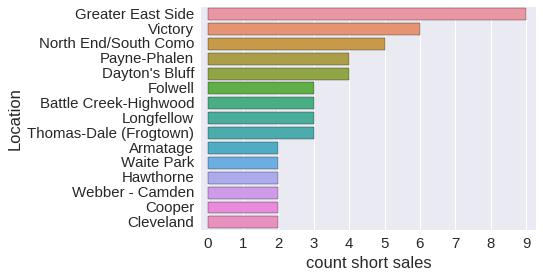

In [52]:
sns.set(font_scale=1.5)
plt.figure(figsize=(6,4))
sns.barplot(temp_df['count'].values,temp_locs #estimator=lambda x:x[0],
            )
plt.xlabel('count short sales')
plt.ylabel('Location')
plt.margins(0.02)
plt.xticks(range(10))
x0, x1, y0, y1 = plt.axis()
plot_margin = 0.1
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))
plt.show()

We do not have really many samples per location

In [53]:
most_short_sales_area = counts_short_sales.iloc[np.argmax(counts_short_sales.values)]
most_short_sales_area

count    9
Name: 25.0, dtype: int64

In [54]:
target_location = int(most_short_sales_area.name)
target_location

25

In [55]:
location_name = df.loc[XX[XX['LOCATION'] == target_location].head(1).index[0], 'LOCATION']
print "So location {} has the most short sales".format(location_name)

So location Greater East Side has the most short sales


Let's answer the question if everywhere is cheaper and smaller, on average, when a Short sale case is involved

In [56]:
comp_table.shape

(33, 6)

In [57]:
comp_table['SQFT_ss'][:3]

LOCATION
0.0    1133.0
1.0    1485.5
3.0    1410.0
Name: SQFT_ss, dtype: float64

In [58]:
sqft_comp = (comp_table['SQFT_ss'] < comp_table['SQFT']).to_frame('sqft')
sqft_comp.shape

(33, 1)

In [59]:
lot_size_comp = (comp_table['LotSize_ss'] < comp_table['LotSize']).to_frame('lot_size')
lot_size_comp.shape

(33, 1)

In [60]:
price_comp = (comp_table['price_ss'] < comp_table['price']).to_frame('price')
price_comp.shape

(33, 1)

In [61]:
comparison = pd.concat((sqft_comp, lot_size_comp, price_comp), axis=1)
comparison.set_index(le.inverse_transform( map(lambda xx: int(xx), comparison.index) )).sample(n=5).rename(
    columns={
        'sqft': 'is median SQFT smaller when shortsale',
        'lot_size': 'is median Lot Size smaller when shortsale',
        'price': 'is median Listing Price smaller when shortsale',
    })

,is median SQFT smaller when shortsale,is median Lot Size smaller when shortsale,is median Listing Price smaller when shortsale
Armatage,True,False,True
Willard - Hay,False,False,True
Howe,True,False,True
Northeast Park,True,True,True
Cleveland,False,False,True


So we observe that per location is different

## Compare with objective value
In this dataset we do NOT have the objective value of a house as this is set by the government

But we can estimate that from the shortsales since we could hypothesize that the shortsales represent a price very near the objective value of the house

We consider in our simplistic example that the government has only available the sqft and the lotsize and this is how the objective value of the house is determined but this is done per location

In [62]:
shortSales30 = shortSales[shortSales['LOCATION']==target_location]
shortSales30.shape

(9, 49)

In [63]:
inputs = shortSales30[['SQFT', 'LotSize']]
targets = shortSales30['price']
inputs.shape, targets.shape

((9, 2), (9,))

We also assume the government has a simplistic linear formula to derive the objective value of a house

In [64]:
gov_model = LinearRegression(normalize=True).fit(inputs, targets)
gov_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [65]:
gov_model.score(inputs, targets)

0.52658123401629198

First of all we define what a good deal is. A good deal we say is defined if we have the price nearest to the objective value, otherwise the price is

So now using this model we calculate the objective value of all the houses and then we subtract the actual value to see how good of a deal we get

In [66]:
XX30 = XX[XX['LOCATION'] == target_location]
XX30.shape

(52, 48)

In [67]:
objective_prices = gov_model.predict(XX30[['SQFT', 'LotSize']])
objective_prices.shape

(52,)

In [68]:
list_prices = yy[XX['LOCATION'] == target_location]
list_prices.shape

(52,)

In [69]:
how_good_deal = objective_prices - list_prices
how_good_deal.shape

(52,)

In [70]:
how_good_deal_normals = how_good_deal[XX30['ShortSale']==False]
how_good_deal_normals.shape

(43,)

In [71]:
how_good_deal_ss = how_good_deal[XX30['ShortSale']==True]
how_good_deal_ss.shape

(9,)

In [72]:
how_good_deal_normals

ID
4421741    -37614.246948
4440232    -49876.518195
4424954     -7100.212974
4424069     69676.473537
4437449    -31944.025380
4421949    -21184.147989
4413767    -30822.561691
4439700    -76895.875885
4440678     -7470.938624
4429604    -67797.589009
4428009    -48789.702553
4433509    -13563.127955
4436989    -20447.015818
4379870    -14876.096835
4429472     -4254.039384
4440663      7195.656654
4427697    -74381.542902
4440256     21162.355735
4440914    -70387.451376
4339473     96633.265700
4440058      4719.436799
4439595    -22778.677676
4406207   -110237.998174
4431781    -29154.636594
4437522    -44067.156029
4436904    -14026.942633
4428053     15519.728103
4437323    -45445.965535
4433516    -15798.492523
4441218    -59572.162258
4394200    -22860.921133
4435052     -6970.020848
4415256    -26026.820244
4394547      4605.942279
4422118    -28247.459324
4440793     23686.289128
4411464    -15806.486330
4439702    -25819.239723
4428765    -50538.924877
4434676    -24942.6759

In [73]:
how_good_deal_ss

ID
4398012   -19807.469480
4434836      -91.628477
4441246    36550.870638
4391715     7636.004320
4427450    33029.326035
4432160   -23041.793552
4388484    -4777.593703
4427000     8020.401100
4397338   -37518.116882
Name: ListPrice, dtype: float64

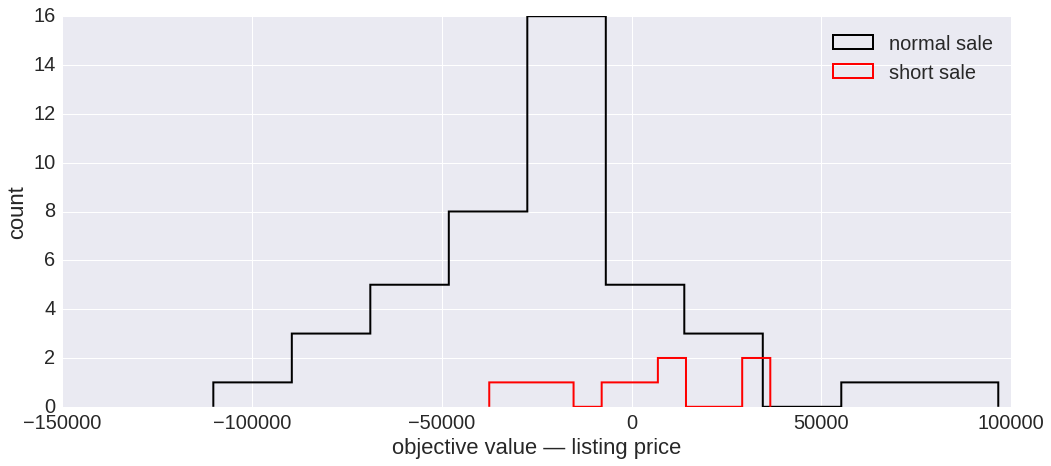

In [74]:
sns.set(font_scale=2)
plt.figure(figsize=(17,7))
plt.hist(how_good_deal_normals, histtype='step', color='black', linewidth=2, label='normal sale')
plt.hist(how_good_deal_ss, histtype='step', color='red', linewidth=2, label='short sale')
plt.xlabel(u'objective value — listing price')
plt.ylabel('count')
plt.legend(loc='best')
plt.show()

#### conclusions
Comparing this plot we see that there are many cases where the houses which are NOT short sales are quite expensive

but there are also cases where the short sales seem to be higher than the objective value of the house

The surprise is that there are cases where the value is much better than the objective value of the house and this is not a short sale.  
We could hypothesize that this is a house whose residents are in a financial crisis but they don't owe anything to a bank or to another lender in order to set it as short sale

#### note
Finally we must stress that we cannot say that for other locations since we only have a very limited amount of short sales per location from which we could determine the weights that play a role for estimating the objective value

# Extra exploration

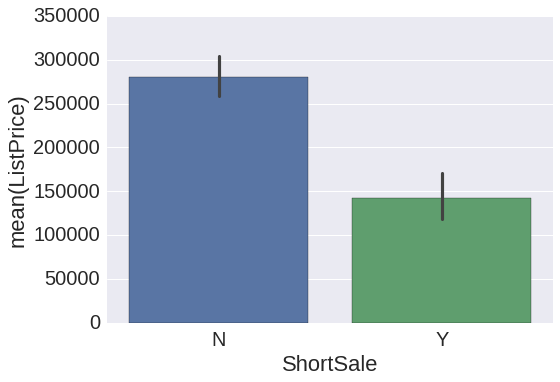

In [75]:
sns.barplot(data=df, x='ShortSale', y='ListPrice')

In [76]:
from matplotlib import rcParams

In [77]:
rcParams['figure.figsize'] = 15, 7

In [78]:
from ecdf import ecdf, plot_ecdf_bootstrap_replicates

In [79]:
yy.shape

(1111,)

In [80]:
short_sale_prices = yy[XX['ShortSale'] == 1]
normal_sale_prices = yy[XX['ShortSale'] == 0]

In [81]:
plot_ecdf_bootstrap_replicates(100, random_state, , 'short sale')
plot_ecdf_bootstrap_replicates(10, random_state, yy[XX['ShortSale'] == 0], 'NOT short sale')
plt.xscale('log')
#ax = plt.gca()
leg = plt.legend(['short sale: blue', 'normal sale: green'], loc='best')
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('yellow')
plt.show()

SyntaxError: invalid syntax (<ipython-input-81-077d92473484>, line 1)

From the ecdf it is obvious that the distributions are quite different.

So fir a price of 100,000 we have already 40% of shortsales being below that while only ~20% of normal sales are below this price

# Hypothesis check. Do short sales prices have the same distribution?
T-statistic: Our test statistic will be the mean value and the variance

Null hypothesis: We are saying that shortsale prices have the same distribution as the rest of the normal prices

Under this assumption we are going to permute the prices and measure our test metric lots of times

If we get a measurement of a difference in the mean value only a few times then this means that we have to reject the null hypothesis

In [82]:
from permutation_replicates import draw_perm_reps

In [83]:
from test_statistics import diff_of_means

In [84]:
observed_mean_diff = diff_of_means(normal_sale_prices, short_sale_prices)
#keep the same order (first normal then short sales) below
observed_mean_diff

138318.0999419326

In [85]:
#abs_diff_means = lambda aa, bb : abs(diff_of_means(aa,bb))

In [89]:
%%time
diff_means = draw_perm_reps(normal_sale_prices, short_sale_prices, diff_of_means, size=100000,
                                 random_state = random_state)
diff_means = np.array(diff_means)
diff_means.shape

CPU times: user 6.3 s, sys: 0 ns, total: 6.3 s
Wall time: 6.29 s


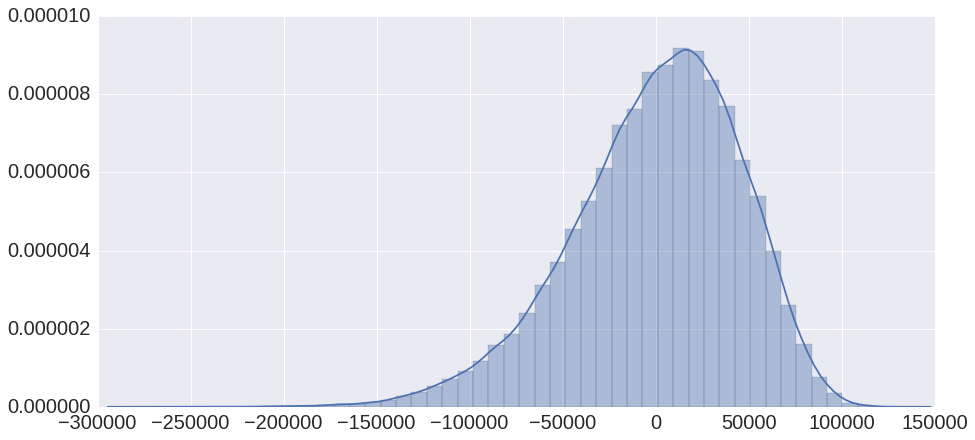

In [90]:
sns.distplot(diff_means)
plt.show()

In [91]:
p_value = np.sum(diff_means >= observed_mean_diff) / len(diff_means)
p_value

0.0

0.0 % means extremely low and this means that our hypothesis is rejected but let's test also with the other test statistic, the variance

In [92]:
from test_statistics import diff_of_stds

In [93]:
observed_diff_std = diff_of_stds(normal_sale_prices, short_sale_prices)
observed_diff_std

262136.68186060127

In [96]:
%%time
diff_stds = draw_perm_reps(normal_sale_prices, short_sale_prices, diff_of_stds, size=100000,
                           random_state = random_state)
diff_stds = np.array(diff_stds)
diff_stds.shape

CPU times: user 11.3 s, sys: 16 ms, total: 11.3 s
Wall time: 11.3 s


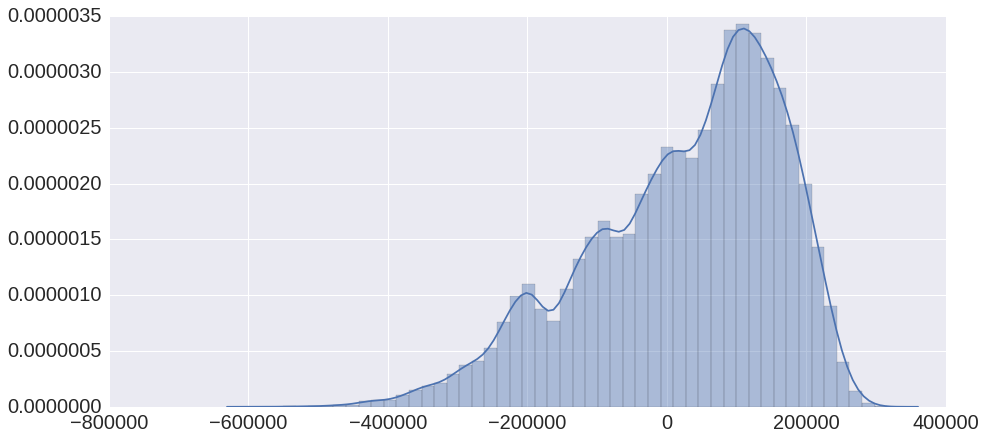

In [97]:
sns.distplot(diff_stds)
plt.show()

In [98]:
p_value = np.sum(diff_stds >= observed_diff_std) / len(diff_stds)
p_value

0.00331

Again we have witnessed such an extreme difference very few times: 0.3%

## First relaxing accepting symmetric differences
This is just to check if the absolute differences will bring a higher p-value

In [99]:
abs_diff_means = lambda aa, bb : abs(diff_of_means(aa,bb))

In [100]:
observed_mean_diff = abs_diff_means(short_sale_prices, normal_sale_prices)
#keep the same order (first normal then short sales) below
observed_mean_diff

138318.0999419326

In [101]:
%%time
diff_means = draw_perm_reps(normal_sale_prices, short_sale_prices, abs_diff_means, size=100000,
                                 random_state = random_state)
diff_means = np.array(diff_means)
diff_means.shape

CPU times: user 6.52 s, sys: 16 ms, total: 6.54 s
Wall time: 6.53 s


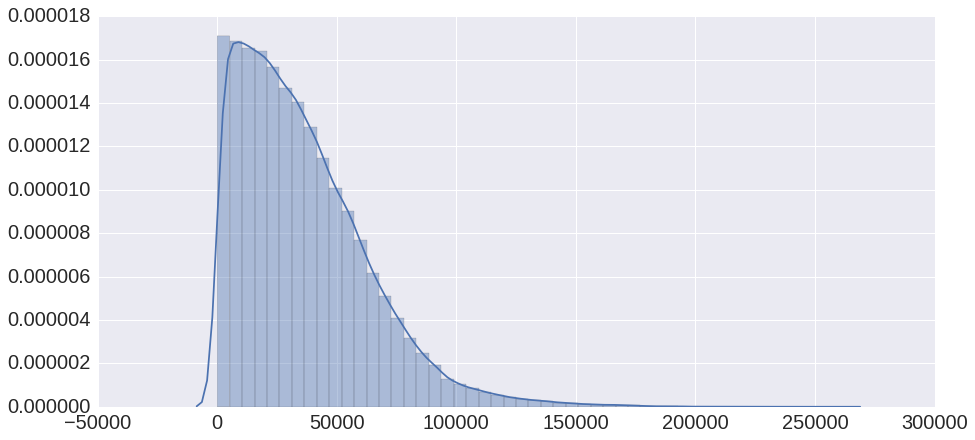

In [102]:
sns.distplot(diff_means)
plt.show()

In [103]:
p_value = np.sum(diff_means >= observed_mean_diff) / len(diff_means)
p_value

0.0054900000000000001

0.5 % is very low and this means that our hypothesis is rejected but let's test also with the other test statistic, the variance to be even more sure

In [104]:
abs_diff_stds = lambda aa, bb : abs(diff_of_stds(aa, bb))

In [105]:
observed_diff_std = abs_diff_stds(short_sale_prices, normal_sale_prices)
observed_diff_std

262136.68186060127

In [108]:
%%time
diff_stds = draw_perm_reps(normal_sale_prices, short_sale_prices, abs_diff_stds, size=100000,
                           random_state = random_state)
diff_stds = np.array(diff_stds)
diff_stds.shape

CPU times: user 11.3 s, sys: 4 ms, total: 11.3 s
Wall time: 11.3 s


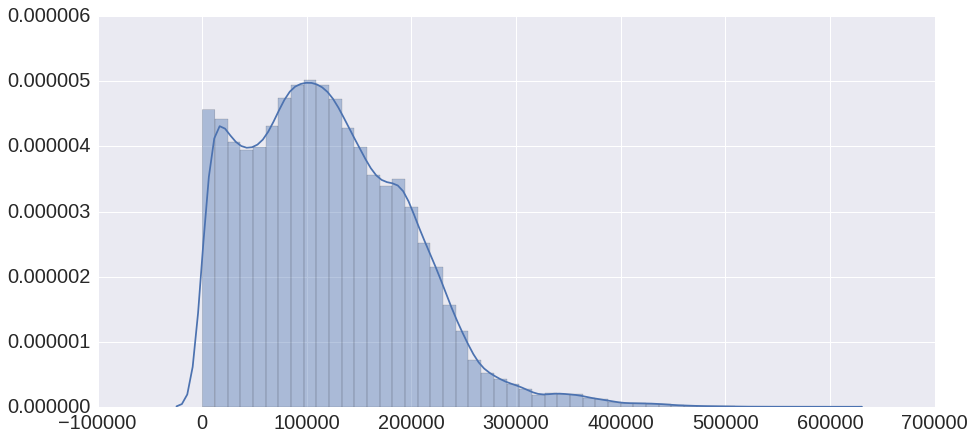

In [109]:
sns.distplot(diff_stds)
plt.show()

In [110]:
p_value = np.sum(diff_stds >= observed_diff_std) / len(diff_stds)
p_value

0.038219999999999997

We see that the differences of the variances are not that high and if we set our threshold to 0.01 we could say that due to the variance test statistic the null hypothesis cannot be fully rejected. However if we set the threshold to 0.05 as it is also quite common then we are going to consider also this test statistic to be a rejection of the null hypothesis

# Second ever larger relaxation
We are NOT claiming that we have two identical distributions but rather that we have similar mean values. Then below we are going to check for similar variances

In [111]:
observed_diff_means = diff_of_means(normal_sale_prices, short_sale_prices)
observed_diff_means

138318.0999419326

Null hypotheis that they have different distributions but same mean

So under the assumption that the null hypothesis is true.. <-- this is realized by forcing the means to be equal to the global mean
..we check whether there are as extreme values as the ones we observed by bootstraping.
If there are only a few large values this means that the original difference is significant and we need to reject the original null hypothesis

In [113]:
global_mean = np.mean(yy)
global_mean

271408.0207020702

In [114]:
trans_normal_sales = normal_sale_prices - np.mean(normal_sale_prices) + global_mean
trans_normal_sales.shape

(1038,)

In [116]:
trans_short_sales = short_sale_prices - np.mean(short_sale_prices) + global_mean
trans_short_sales.shape

(73,)

In [119]:
assert np.mean(np.concatenate((trans_normal_sales, trans_short_sales))) == global_mean
#try np.allclose if it fails

In [120]:
from bootstrap_replicates import draw_bootstrap_replicates

In [125]:
normal_reps = draw_bootstrap_replicates(np.mean, 100000, random_state, trans_normal_sales)
normal_reps = np.array(normal_reps)
normal_reps.shape

(100000,)

In [126]:
ss_reps = draw_bootstrap_replicates(np.mean, 100000, random_state, trans_short_sales)
ss_reps = np.array(ss_reps)
ss_reps.shape

(100000,)

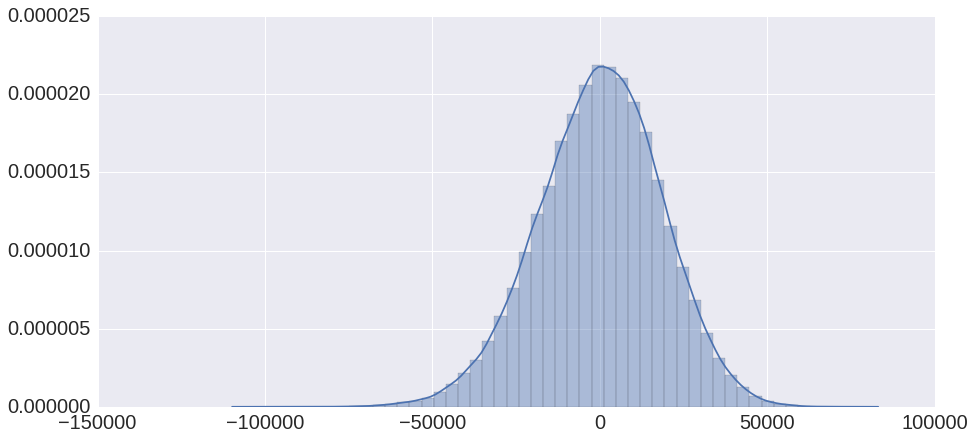

In [127]:
mean_diffs = normal_reps - ss_reps
sns.distplot(mean_diffs)
plt.show()

In [128]:
p_value = np.sum(mean_diffs >= observed_diff_means) / len(mean_diffs)
p_value

0.0

So we have to reject the hypothesis that the average values are the same

# Check if variances are the same
Even if they do not come out of the same distribution

In [129]:
observed_diff_stds = diff_of_stds(normal_sale_prices, short_sale_prices)
observed_diff_stds

262136.68186060127

In [130]:
global_std = np.std(yy)

In [132]:
scaled_normals = (normal_sale_prices / np.std(normal_sale_prices)) * global_std
scaled_shorts = (short_sale_prices / np.std(short_sale_prices)) * global_std

In [135]:
assert np.allclose(np.std(scaled_normals), np.std(scaled_shorts))
assert np.allclose(np.std(scaled_normals), global_std)

In [136]:
%%time
bs_reps_normals = draw_bootstrap_replicates(np.std, int(1e5), random_state, scaled_normals)
bs_reps_normals = np.array(bs_reps_normals)
bs_reps_normals.shape

CPU times: user 9.49 s, sys: 0 ns, total: 9.49 s
Wall time: 9.5 s


In [137]:
%%time
bs_reps_shorts = draw_bootstrap_replicates(np.std, int(1e5), random_state, scaled_shorts)
bs_reps_shorts = np.array(bs_reps_shorts)
bs_reps_shorts.shape

CPU times: user 6.66 s, sys: 0 ns, total: 6.66 s
Wall time: 6.66 s


In [138]:
std_diffs = bs_reps_normals - bs_reps_shorts
std_diffs.shape

(100000,)

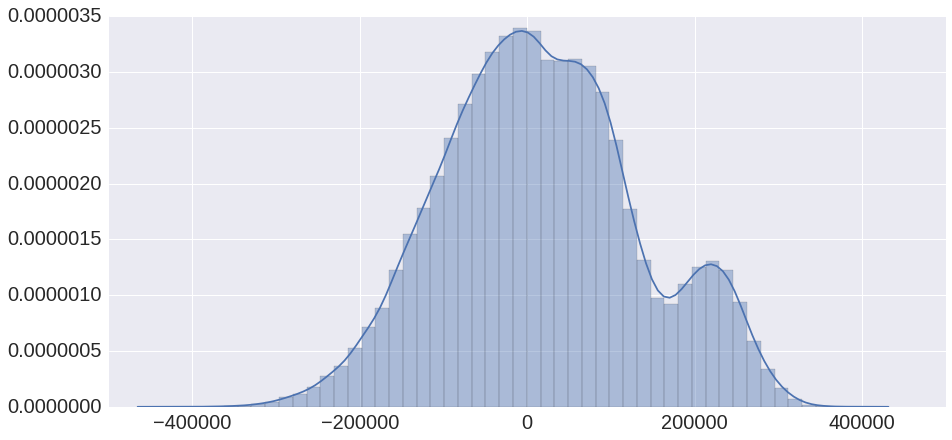

In [139]:
sns.distplot(std_diffs)
plt.show()

In [140]:
observed_diff_stds

262136.68186060127

In [141]:
p_value = np.sum(std_diffs >= observed_diff_stds) / len(std_diffs)
p_value

0.019869999999999999

p_value is not small and therefore we could say that we cannot completely reject the hypothesis that the standard deviations of normal sales and short sales are not the same

# Final ever larger relaxation
We are NOT claiming that we have two identical distributions but rather that we have similar mean values. Then below we are going to check for similar variances. Now we are even considering opposite sign to be the same. That is why we are taking the absolute difference

In [142]:
observed_diff_means = abs_diff_means(normal_sale_prices, short_sale_prices)
observed_diff_means

138318.0999419326

Null hypotheis that they have different distributions but same mean

So under the assumption that the null hypothesis is true.. <-- this is realized by forcing the means to be equal to the global mean
..we check whether there are as extreme values as the ones we observed by bootstraping.
If there are only a few large values this means that the original difference is significant and we need to reject the original null hypothesis

In [143]:
global_mean = np.mean(yy)
global_mean

271408.0207020702

In [144]:
trans_normal_sales = normal_sale_prices - np.mean(normal_sale_prices) + global_mean
trans_normal_sales.shape

(1038,)

In [145]:
trans_short_sales = short_sale_prices - np.mean(short_sale_prices) + global_mean
trans_short_sales.shape

(73,)

In [150]:
assert np.mean(np.concatenate((trans_normal_sales, trans_short_sales))) == global_mean
#try np.allclose if it fails

In [151]:
from bootstrap_replicates import draw_bootstrap_replicates

In [152]:
%%time
normal_reps = draw_bootstrap_replicates(np.mean, 100000, random_state, trans_normal_sales)
normal_reps = np.array(normal_reps)
normal_reps.shape

CPU times: user 6.96 s, sys: 0 ns, total: 6.96 s
Wall time: 6.96 s


In [153]:
%%time
ss_reps = draw_bootstrap_replicates(np.mean, 100000, random_state, trans_short_sales)
ss_reps = np.array(ss_reps)
ss_reps.shape

CPU times: user 4.4 s, sys: 4 ms, total: 4.4 s
Wall time: 4.4 s


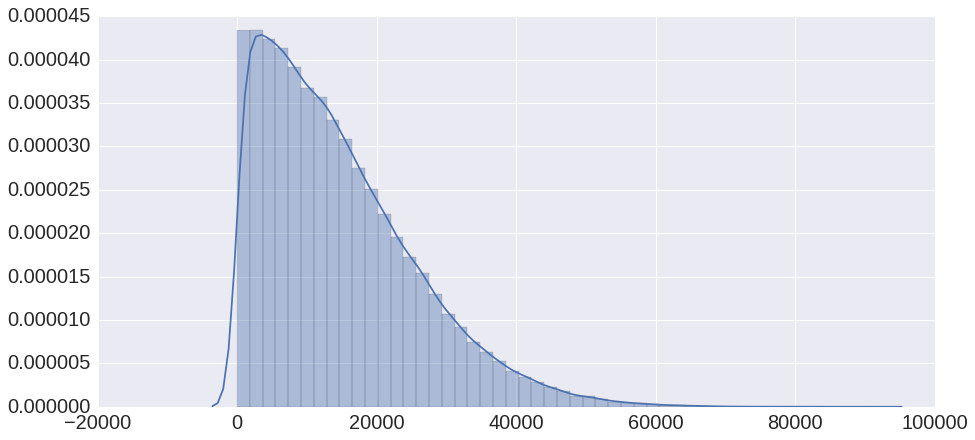

In [154]:
mean_diffs = np.abs(normal_reps - ss_reps)
sns.distplot(mean_diffs)
plt.show()

In [155]:
p_value = np.sum(mean_diffs >= observed_diff_means) / len(mean_diffs)
p_value

0.0

So we have to reject the hypothesis that the average values are the same

# Check if variances are the same
Even if they do not come out of the same distribution

In [156]:
observed_diff_stds = abs_diff_stds(normal_sale_prices, short_sale_prices)
observed_diff_stds

262136.68186060127

In [157]:
global_std = np.std(yy)

In [158]:
scaled_normals = (normal_sale_prices / np.std(normal_sale_prices)) * global_std
scaled_shorts = (short_sale_prices / np.std(short_sale_prices)) * global_std

In [159]:
assert np.allclose(np.std(scaled_normals), np.std(scaled_shorts))
assert np.allclose(np.std(scaled_normals), global_std)

In [160]:
%%time
bs_reps_normals = draw_bootstrap_replicates(np.std, int(1e5), random_state, scaled_normals)
bs_reps_normals = np.array(bs_reps_normals)
bs_reps_normals.shape

CPU times: user 9.38 s, sys: 0 ns, total: 9.38 s
Wall time: 9.38 s


In [161]:
%%time
bs_reps_shorts = draw_bootstrap_replicates(np.std, int(1e5), random_state, scaled_shorts)
bs_reps_shorts = np.array(bs_reps_shorts)
bs_reps_shorts.shape

CPU times: user 6.78 s, sys: 0 ns, total: 6.78 s
Wall time: 6.78 s


In [162]:
std_diffs = np.abs(bs_reps_normals - bs_reps_shorts)
std_diffs.shape

(100000,)

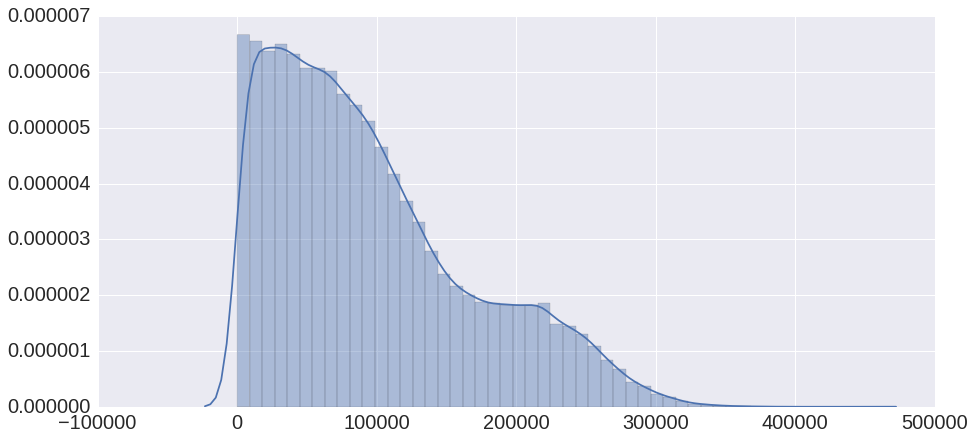

In [163]:
sns.distplot(std_diffs)
plt.show()

In [164]:
observed_diff_stds

262136.68186060127

In [165]:
p_value = np.sum(std_diffs >= observed_diff_stds) / len(std_diffs)
p_value

0.02537

p_value is not small and therefore we could say that we cannot completely reject the hypothesis that the standard deviations of normal sales and short sales are not the same